In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit, prange

import tables
import os

cs137_co60.h5 (File) ''
Last modif.: 'Sun Sep 30 12:17:15 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(83439,), shuffle, zlib(1)) ''
/RawData (EArray(83439, 4096), shuffle, zlib(1)) ''

83439


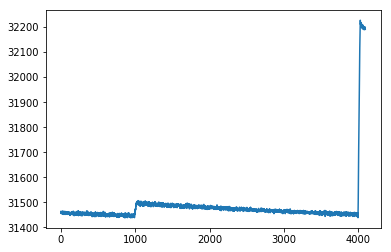

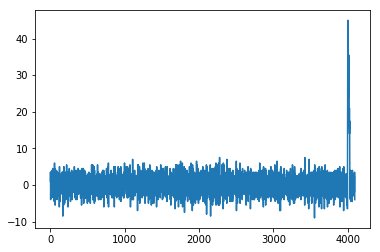

In [48]:
h5file = tables.open_file("cs137_co60.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData
print(len(EventData))



plt.figure()
plt.plot(data[2422,:])
plt.figure()
plt.plot(np.gradient(data[2422,:]))
plt.show()

In [53]:
# Find pulses that triggered multiple times and delete them
i_pileup = 0
j_pileup = 0
pileup_args = np.array([])
EventDataArray = np.array(EventData)

for x in range(len(EventData)):
    if int(EventData[x][3])>1:
        pileup_args = np.append(pileup_args,i_pileup)
        j_pileup = j_pileup+1  
    i_pileup = i_pileup+1

print(data)
print(len(pileup_args))

data = np.delete(data[:], pileup_args, 0)
    
print('deleted ', len(pileup_args),' signals due to pile up')
print(len(data2))

/RawData (EArray(83439, 4096), shuffle, zlib(1)) ''
999


/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


deleted  999  signals due to pile up
82440


In [54]:
@jit(parallel = True)
def TrapFilter(mysignal,tau):
    GradSignal = np.gradient(mysignal)
    argPeak = np.argmax(GradSignal)
    avgNoise = np.mean(mysignal[0:argPeak-5])
    newSignal = mysignal - avgNoise
#    
#    @jit(parallel = True)
#    def func(x, a, b):
#        return a * np.exp(-b * x)
#
#    popt, pcov = curve_fit(func, range(0,len(newSignal)-argPeak), newSignal[argPeak:])
#    tau = 1/popt[1]
    
    #signalOnly = newSignal[argPeak:]
    signalOnly = newSignal
    m=40
    #k=int((len(signalOnly)-m)/2)
    #k = peaking time
    #m= Gap time (in samples)
    k=100
    M = tau
    Acc1=0.0
    Acc2=0.0
    l =2*k+m
    final = list(range(len(signalOnly)))
    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    while i < len(signalOnly):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)
    #/max(final)
    return normFinal

In [159]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals = makesignals(data)

print(datetime.now() - startTime)

82440
0:00:05.145184


In [153]:
@jit(parallel = True)
def func(x, a, b):
    return a * np.exp(-b * x)

In [168]:

#tau = np.zeros(events)
#trap_out = np.zeros((events,cols))

@jit(parallel = True)
def eventsProcess(mysignal, events, cols):
#    tau = np.zeros(events)
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in prange(0,events):
#        print(j)
        mysignal = mysignals[j,:]
#        GradSignal = np.gradient(mysignal)
#        argPeak = np.argmax(GradSignal)
        avgNoise = np.mean(mysignal[0:900])
        newSignal = mysignal - avgNoise
    #    plt.figure()
    #    plt.plot(newSignal)

#        @jit(parallel = True)
#        def func(x, a, b):
#            return a * np.exp(-b * x)

#        popt, pcov = curve_fit(func, range(0,len(newSignal)-1050), newSignal[1050:])
    #    print(popt)
#        tau[j] = 1.0/popt[1]
        trap_out[j] = TrapFilter(mysignals[j,:],6179.29)
#    print('Average Tau across all signals',np.mean(tau))
    print(datetime.now() - startTime)
    return trap_out

In [172]:
print(len(mysignals))
events = len(mysignals)
trap_out = eventsProcess(mysignal, events, cols)

82440


/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0:50:33.466997


4096
1115


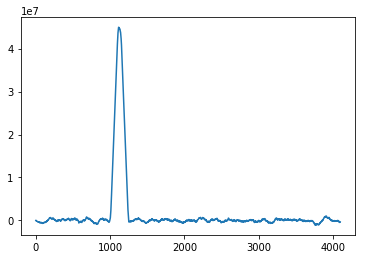

In [173]:
plt.figure()
plt.plot(trap_out[100][:])
print(len(trap_out[0]))
print(np.argmax(trap_out[100][:]))

In [148]:
#from scipy.interpolate import UnivariateSpline
#spline = UnivariateSpline(trap_out[100][:])

In [149]:
#print(len(trap_out[100]))
#print(FWHM(trap_out[100][:],range(len(trap_out[100]))))

In [174]:
counts = []
for j in range(0,len(trap_out)):
    counts = np.append(counts,np.amax(trap_out[j]))

[7.09710160e+07 5.37839610e+07 4.41574010e+07 ... 1.60159432e+08
 2.10631675e+08 7.48860670e+07]


(array([5.000e+00, 0.000e+00, 1.100e+01, 1.290e+02, 3.530e+02, 7.060e+02,
        9.710e+02, 1.260e+03, 1.618e+03, 2.149e+03, 2.605e+03, 2.735e+03,
        2.901e+03, 2.866e+03, 2.799e+03, 2.870e+03, 2.656e+03, 2.545e+03,
        2.404e+03, 2.305e+03, 2.100e+03, 1.989e+03, 1.794e+03, 1.615e+03,
        1.465e+03, 1.598e+03, 1.464e+03, 1.362e+03, 1.262e+03, 1.140e+03,
        1.108e+03, 1.038e+03, 9.630e+02, 9.950e+02, 7.880e+02, 7.440e+02,
        6.670e+02, 6.500e+02, 5.610e+02, 5.750e+02, 5.630e+02, 5.230e+02,
        4.690e+02, 4.630e+02, 4.060e+02, 4.090e+02, 4.020e+02, 4.590e+02,
        4.500e+02, 4.090e+02, 3.240e+02, 3.280e+02, 3.410e+02, 3.300e+02,
        3.230e+02, 3.060e+02, 2.770e+02, 2.850e+02, 3.000e+02, 3.090e+02,
        2.730e+02, 2.900e+02, 2.370e+02, 2.730e+02, 2.950e+02, 2.410e+02,
        2.540e+02, 2.220e+02, 2.110e+02, 1.750e+02, 2.080e+02, 2.360e+02,
        1.610e+02, 1.750e+02, 1.550e+02, 1.610e+02, 1.530e+02, 1.460e+02,
        1.600e+02, 1.380e+02, 1.280e+0

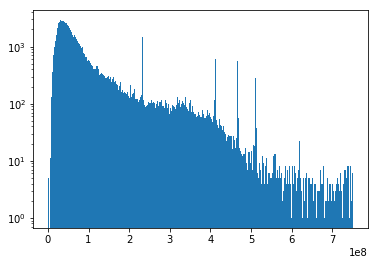

In [180]:
print(np.trim_zeros(counts))
counts2 = np.trim_zeros(counts)
counts3 = counts2[(counts2>0) & (counts2<0.75e9)]
plt.figure()
plt.yscale('log')
plt.hist(counts3,bins=300)